<a href="https://colab.research.google.com/github/ivasmoljko/PhotoMath/blob/main/PhotomathIvaSmoljko_finalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Photomath - Iva Smoljko

## Libraries

First of all, let's import all the libraries we will use.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
import os
from sklearn import preprocessing
from pathlib import Path
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## Uploading the data

Now, we will install kaggle so we can directly get dataset.

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d clarencezhao/handwritten-math-symbol-dataset

 85% 49.0M/57.8M [00:03<00:00, 13.0MB/s]
100% 57.8M/57.8M [00:03<00:00, 17.0MB/s]


In [ ]:
! unzip handwritten-math-symbol-dataset.zip

After loading and unzipping the dataset, we can see that in the "train" file (located in "content" file) there are files which contain images of handwritten digits and basic mathematical operators (+,-,* and /). There are files which have handwritten decimal point, sign equal as well, but due to the fact that it is not part of our task, I will be ignoring it. However, this dataset does not contain bracket "(" and ")" data, so my Photomath won't be able to recognize it. 

Let's create a list with labels (names of digits and symbols we will use).

In [ ]:
labels = ['zero','one','two','three','four','five','six','seven','eight','nine',
          'plus','minus','times','div']

We need to load images for training (from "train" file) and testing (from file "eval").

In [ ]:
train_dataset_path = "../content/train"
train_image = []
train_label = []

for labels_dir in os.listdir(train_dataset_path): 
    if labels_dir.split()[0] in labels: #since our labels are one-word, 
    #we split the name of file and only observe if the first word is in
    #array
        for image in os.listdir(train_dataset_path + "/" + labels_dir):
            train_label.append(labels_dir.split()[0])
            train_image.append(train_dataset_path + "/" + labels_dir + "/" + image)

In [ ]:
test_dataset_path = "../content/eval"
test_image = []
test_label = []

for labels_dir in os.listdir(test_dataset_path):
    if labels_dir.split()[0] in labels:
        for image in os.listdir(test_dataset_path + "/" + labels_dir):
            test_label.append(labels_dir.split()[0])
            test_image.append(test_dataset_path + "/" + labels_dir + "/" + image)

Let's check how many train and test images we have (and if we did this correctly; number of images should be equal to length of array with labels).

In [ ]:
print("Total of train_image: ", len(train_image), ", length of labels list : " ,len(train_label))
print("Total of test_image : " , len(test_image) , ", length of labels list : " ,len(test_label))

Total of train_image:  6490 , length of labels list :  6490
Total of test_image :  854 , length of labels list :  854


In [ ]:
#ratio
len(train_image)/(len(train_image) + len(test_image))

0.8837145969498911

As we can see, the numbers of images and labels correspond to each other, and the ratio of training and testing images is nearly 90:10, which we still consider as a "good radio". 

Let's plot random images from train and test dataset.

In [ ]:
import random

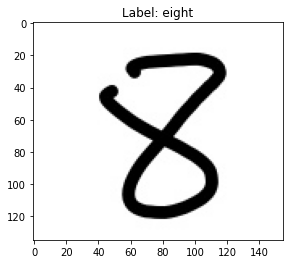

In [ ]:
random.seed()
rd = random.randint(1, len(train_image))
image = cv2.imread(train_image[rd])
plt.imshow(image)
plt.title("Label: " + train_label[rd])
plt.show()

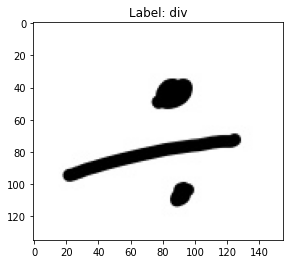

In [ ]:
random.seed()
rd1 = random.randint(1, len(test_image))
image = cv2.imread(train_image[rd1])
plt.imshow(image)
plt.title("Label: " + train_label[rd1])
plt.show()

Now, let's check height and width of our images.

In [ ]:
train_shapes = []
train_width = []
train_height = []
for path in train_image:
  img = np.array(cv2.imread(path))
  size = img.shape
  if size not in train_shapes:
    train_shapes.append(size) 
    train_width.append(size[0])
    train_height.append(size[1])

if len(train_shapes):
  print("min train width: ", min(train_width))
  print("min train height: ", min(train_height))

min train width:  135
min train height:  150


In [ ]:
test_shapes = []
test_width = []
test_height = []
for path in test_image:
  img = np.array(cv2.imread(path))
  size = img.shape
  if size not in test_shapes:
    test_shapes.append(size)
    test_width.append(size[0])
    test_height.append(size[1])

if len(train_shapes):
  print("min test width: ", min(test_width))
  print("min test height: ", min(test_height))

min test width:  135
min test height:  150


Cleary, they differ in sizes. So, to make things easier for later, we will resize them (not a lot) and make them square. Also, our data is in .jpg format, we need to convert it to numpy array.

## Preparing the data

In [ ]:
X_train = []
X_test = []

for path in train_image:    
    img = cv2.imread(path)
    img = cv2.resize(img, (135, 135))
    img = np.array(img)
    X_train.append(img)

for path in test_image:    
    img = cv2.imread(path)
    img = cv2.resize(img, (135, 135))
    img = np.array(img)     
    X_test.append(img)

# X_train and X_test are basic arrays, we will convert them to numpy array 
X_train = np.array(X_train)
X_test = np.array(X_test)

Since normalization reduces the complexity of the problem our network is trying to solve, we will normalize data. This can potentially increase the accuracy of our model and speed up the training, because we bring the data on the same scale and reduce variance along with none of the weights in the network are wasted on doing a normalization for us, meaning that they can be used more efficiently to solve the actual task at hand.

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (6490, 135, 135, 3)
X_test shape:  (854, 135, 135, 3)


We need to adjust labels.

In [ ]:
label_encoder = preprocessing.LabelEncoder()
y_train_temp = label_encoder.fit_transform(train_label)
y_test_temp = label_encoder.fit_transform(test_label)

In [ ]:
for i in range(len(labels)):
  print(label_encoder.classes_[i], "is encoded as: ", i)

div is encoded as:  0
eight is encoded as:  1
five is encoded as:  2
four is encoded as:  3
minus is encoded as:  4
nine is encoded as:  5
one is encoded as:  6
plus is encoded as:  7
seven is encoded as:  8
six is encoded as:  9
three is encoded as:  10
times is encoded as:  11
two is encoded as:  12
zero is encoded as:  13


In [ ]:
print("y_train_temp shape: ", y_train_temp.shape)
print("y_test_temp shape: ", y_test_temp.shape)

y_train_temp shape:  (6490,)
y_test_temp shape:  (854,)


Next, we need to create a matrix labels list.

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train_temp, len(labels))
y_test = tf.keras.utils.to_categorical(y_test_temp, len(labels))


print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (6490, 14)
y_test shape:  (854, 14)


## Model

Now, everything is ready for creating our model. We will use sequential model, which means we can do it "layer-by-layer".

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(135, 135, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))

# Maxpooling takes the highest value from a filter of 2*2 shape
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout prevent overfitting by making it hard for the model to idenify the images
model.add(Dropout(0.25))

# for deeper layers we increase the number of filters
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# last layer predicts 14 labels
model.add(Dense(len(labels), activation="softmax"))

In a neural network, the activation function is responsible for transforming the summed weighted input from the node into the activation of the node or output for that input. All my activations are "relu". It's definition is $ f(x)= max\{ x,0 \}$. I used it mostly because it has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

In the last layer I used "softmax". Softmax is a function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. 


Time to compile the model.

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 135, 135, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 133, 133, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 66, 66, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 66, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

I used metrics "accuracy". As it's name says, that metrics computes how many of predicted labels correspond to the real labels.

Let's train model.

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=200,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/200
104/104 [==============================] - 30s 174ms/step - loss: 1.8210 - accuracy: 0.4178 - val_loss: 9.3377 - val_accuracy: 0.0485
Epoch 2/200
104/104 [==============================] - 16s 149ms/step - loss: 0.6816 - accuracy: 0.7824 - val_loss: 12.0035 - val_accuracy: 0.1156
Epoch 3/200
104/104 [==============================] - 16s 150ms/step - loss: 0.3800 - accuracy: 0.8844 - val_loss: 14.9229 - val_accuracy: 0.1533
Epoch 4/200
104/104 [==============================] - 16s 150ms/step - loss: 0.2115 - accuracy: 0.9307 - val_loss: 17.8850 - val_accuracy: 0.1764
Epoch 5/200
104/104 [==============================] - 16s 150ms/step - loss: 0.1502 - accuracy: 0.9528 - val_loss: 19.6973 - val_accuracy: 0.1595
Epoch 6/200
104/104 [==============================] - 16s 151ms/step - loss: 0.1007 - accuracy: 0.9655 - val_loss: 22.5757 - val_accuracy: 0.1579
Epoch 7/200
104/104 [==============================] - 16s 151ms/step - loss: 0.0863 - accuracy: 0.9713 - val_loss: 22.

We will visualize the outcome and model loss.

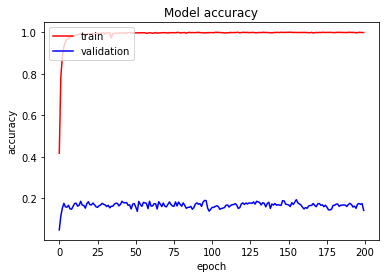

In [ ]:
plt.plot(history.history['accuracy'], label='train', color="red")
plt.plot(history.history['val_accuracy'], label='validation', color="blue")
plt.title('Model accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

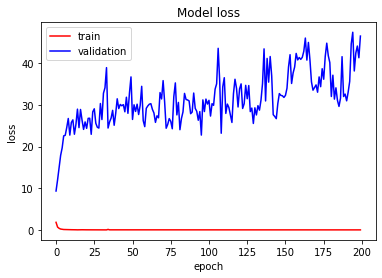

In [ ]:
plt.plot(history.history['loss'], label='train', color="red")
plt.plot(history.history['val_loss'], label='validation', color="blue")
plt.title('Model loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
score, acc = model.evaluate(X_train, y_train)
print('Train score:', score)
print('Train accuracy:', acc)

203/203 [==============================] - 7s 33ms/step - loss: 9.3063 - accuracy: 0.8285
Train score: 9.306251525878906
Train accuracy: 0.8285053968429565


In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

27/27 [==============================] - 1s 47ms/step - loss: 9.9876 - accuracy: 0.7763
Test score: 9.987638473510742
Test accuracy: 0.7763466238975525


Based on accuracy, it does not seem to me that we have overlifting problem (the train and test accuracy differ only in 5%). However, the model could predict better, because it fails in 23% cases.

Now, let's see how model predicts (what output we get).

In [ ]:
pred = model.predict(X_test)
pred

array([[1.7753042e-28, 3.3554736e-25, 0.0000000e+00, ..., 0.0000000e+00,
        1.3576239e-31, 4.5648463e-34],
       [2.0486554e-27, 7.1258797e-31, 0.0000000e+00, ..., 4.1959153e-32,
        6.8992592e-33, 5.0887136e-31],
       [1.5872853e-29, 3.5103436e-16, 1.7483005e-36, ..., 4.6406912e-36,
        1.7907472e-32, 1.2634265e-19],
       ...,
       [1.0000000e+00, 2.5607026e-36, 0.0000000e+00, ..., 2.7761039e-32,
        4.5833010e-29, 0.0000000e+00],
       [9.9716127e-01, 5.9545521e-11, 4.8101157e-20, ..., 3.8536365e-15,
        6.4976006e-14, 2.2593079e-23],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

Visualized:

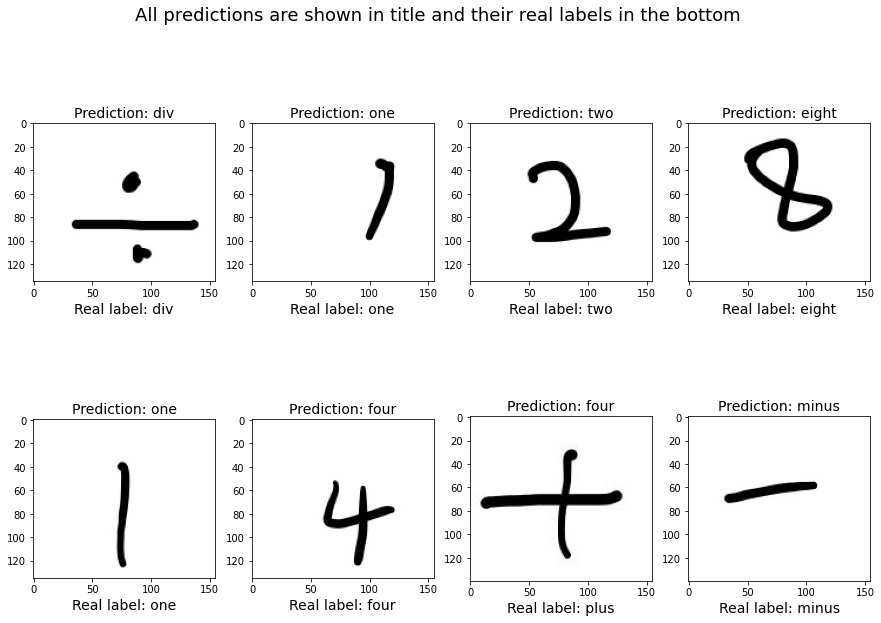

In [ ]:
fig, axs= plt.subplots(2,4, figsize=[15,10])

random_pos = []
count = 0


for i in range(8):
  random.seed()
  random_pos.append(random.randint(1, len(test_image)))


for i in range(2):    
    for j in range(4):  
        
        image = cv2.imread(test_image[random_pos[count]])
      
        img = cv2.resize(image, (135, 135))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img.astype('float32')
        img /= 255
        
        pred = model.predict(img)
        result = np.argsort(pred)
        result = result[0][::-1]
        
        final_label = label_encoder.inverse_transform(np.array(result))
        axs[i][j].imshow(image)
        axs[i][j].set_title(str("Prediction: " + final_label[0]), fontsize = 14)  
        axs[i][j].set_xlabel("Real label: "+ test_label[random_pos[count]], fontsize = 14)      
        
        count += 1
        
plt.suptitle("All predictions are shown in title and their real labels in the bottom", fontsize = 18)        
plt.show()

What's left is to try and test it on simple math equations. Let's import one.
All the data was manually made by me. I merged multiple images from "eval" file and then uploaded it here for testing.

In [ ]:
os.mkdir("test_data")

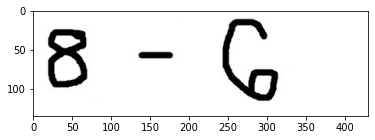

In [ ]:
proba = cv2.imread('../content/test_data/test0.jpg')
plt.imshow(proba)
#print(proba.shape)

Since we can not send this whole image to our model, we need to split it, and send to model every character we find.

To use already implemented functions such as *threshold*, we have to alter the data a little (scaling, changing color from RGB to gray etc). After that, we can use threshold.Thresholding is a technique which assigns pixel values in relation to the threshold value provided. In thresholding, each pixel value is compared with the threshold value. If the pixel value is smaller than the threshold, it is set to 0, otherwise, it is set to a maximum value (generally 255).

Next, we find contours, and make rectangles around them. Because it can happen that for the same figure we get two rectangles, we do a simple check to eliminate the unnecessary ones.

At the end of the coding cell below, we cut original uploaded image by rectangle we got from above explained process. To minimize changing the cropped image's characteristics (in most cases we need to make it bigger so it would be good input for out model) we create a numpy array that contains all values equal to 255 and in the "middle" of it we store values from cropped image. I added the other cases as well, if one of the height and width, or both, are bigger than 135.

In [ ]:
if proba is not None:
  proba_original=proba
  proba=~proba
  proba=cv2.convertScaleAbs(proba)
  proba = cv2.cvtColor(proba, cv2.COLOR_RGB2GRAY)
  

  niz=[]
  _,threshold=cv2.threshold(proba,127,255, cv2.THRESH_BINARY) 
  
  
  ctrs, _=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  cnt=sorted(ctrs, key=lambda ctr:cv2.boundingRect(ctr)[0])
  
  w=int(28)
  h=int(28)
  train_data=[]
  rects=[]
  for c in cnt:
    x,y,w,h = cv2.boundingRect(c)
    rect=[x,y,w,h]
    rects.append(rect)
  #print("rects",rects)
  bool_rect=[]
  for r in rects:
    l=[]
    for rec in rects:
      flag=0
      if rec !=r:
        if r[0]<(rec[0]+rec[2]+10) and rec[0]<(r[0]+r[2]+10) and r[1]<(rec[1]+rec[3]+10) and rec[1]<(r[1]+r[3]+10):
          flag=1
        l.append(flag)
      if rec==r:
        l.append(0)
    bool_rect.append(l)
  #print("bools",bool_rect)
  dump_rect=[]
  for i in range(0,len(cnt)):
    for j in range(0,len(cnt)):
      if bool_rect[i][j] ==1:
        area1=rects[i][2]*rects[i][3]
        area2=rects[j][2]*rects[j][3]
        if(area1==min(area1,area2)):
          dump_rect.append(rects[i])
  #print("dump", dump_rect)
  final_rects=[i for i in rects if i not in dump_rect]
  #print("final", final_rects)
  coord_arrays=[]
  for r in final_rects:
    x=r[0]
    y=r[1]
    w=r[2]
    h=r[3]
    proba_crop=proba_original[y:y+h+10, x:x+h+10]

    coord_array=[]
    for i in range(proba_crop.shape[0]):
      for j in range(proba_crop.shape[1]):
        bool_var = False
        for k in range(3):
          if proba_crop[i,j][k]!=255:
            bool_var=True
        if(bool_var==True):
          coord_array.append((i,j))
        #print(proba_crop[i,j])
    coord_arrays.append(coord_array)

    #print(proba_crop.shape)
    #niz_notreshaped.append(proba_crop)
    #plt.imshow(proba_crop)
    #print(proba_crop.shape)
    #plt.imshow(proba_crop)
    
    #print(proba_crop)
    
    if(proba_crop.shape[0] > 135 and proba_crop.shape[1]> 135):
      proba_resize = cv2.resize(proba_crop,(135,135))
    elif (proba_crop.shape[0] > 135 and proba_crop.shape[1]< 135):
      proba_resize_temp = cv2.resize(proba_crop,(135,proba_crop.shape[1]))
      proba_resize= np.full((135,135,3), 255)
      proba_resize[0:135,
               int((135-proba_crop.shape[1])/2):int((135-proba_crop.shape[1])/2)+proba_crop.shape[1]]= proba_crop
    elif (proba_crop.shape[0] < 135 and proba_crop.shape[1]> 135):
      proba_resize_temp = cv2.resize(proba_crop,(proba_crop.shape[0],135))
      proba_resize= np.full((135,135,3), 255)
      proba_resize[int((135-proba_crop.shape[0])/2):int((135-proba_crop.shape[0])/2)+proba_crop.shape[0],0:135]= proba_crop
    else:
      proba_resize= np.full((135,135,3), 255)
      proba_resize[int((135-proba_crop.shape[0])/2):int((135-proba_crop.shape[0])/2)+proba_crop.shape[0],
               int((135-proba_crop.shape[1])/2):int((135-proba_crop.shape[1])/2)+proba_crop.shape[1]]= proba_crop
    niz.append(proba_resize) 
    
    
    #plt.imshow(proba_resize)
    #print(proba_resize.shape)
    #niz.append(proba_resize)

Down here we print coordinates of a figure, but in original size of a cropped image. Ofcourse, by changing the size (resizing/adding white pixels around image) we change the coordinates.

In [ ]:
for i in range(len(coord_arrays)):
  print("Coordinates of figure ",i+1,"are: ", coord_arrays[i])

Coordinates of figure  1 are:  [(0, 1), (0, 2), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 37), (0, 38), (0, 40), (0, 41), (0, 44), (0, 45), (0, 47), (0, 48), (0, 49), (0, 51), (1, 1), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 44), (1, 45), (1, 47), (1, 49), (1, 50), (1, 52), (2, 2), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26)

Visualizing the "enlarged" cropped images (figures).

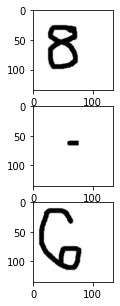

In [ ]:
fig, axs= plt.subplots(len(niz), figsize=[5,5])
for i in range(1):
  for j in range(len(niz)):
    axs[j].imshow(niz[j])

plt.show()

Finally, we do image processing and send it to model for label predicting.

In [ ]:
s= ""
br=0
for i in range(len(niz)):
  niz[i]=np.array(niz[i])

  niz[i] = np.expand_dims(niz[i], axis=0)
  niz[i]=niz[i].astype('float32')
  niz[i]/=255
  
  pred=model.predict(niz[i])
  #print("Pred: ",pred)
  result = np.argsort(pred)
  #print("res:" , result)
  result = result[0][::-1]
  #print("Poredani res: ", result)

  final_label = label_encoder.inverse_transform(np.array(result))
  #print("FL", final_label)
  #print(final_label[0])


  if(final_label[0] == "zero"):
    s+="0"
  if(final_label[0] == "one"):
    s+="1"
  if(final_label[0] == "two"):
    s+="2"
  if(final_label[0] == "three"):
    s+="3"
  if(final_label[0] == "four"):
    s+="4"
  if(final_label[0] == "five"):
    s+="5"
  if(final_label[0] == "six"):
    s+="6"
  if(final_label[0] == "seven"):
    s+="7"
  if(final_label[0] == "eight"):
    s+="8"
  if(final_label[0] == "nine"):
    s+="9"
  if(final_label[0] == "plus"):
    s+="+"
    br+=1
  if(final_label[0] == "minus"):
    s+="-"
    br+=1
  if(final_label[0] == "times"):
    s+="*"
    br+=1
  if(final_label[0] == "div"):
    s+="/"
    br+=1    

if(br!=1):
  print("Probably not expression what you wrote. Model predicted that you wrote: ",s)
else:
  print("Math expression that needs to be solved: ",s)

Math expression that needs to be solved:  8-3


In [ ]:
def MakeANum(s):
  br=0
  for j in range(1,len(s)+1):
    br+= int(s[j-1])*pow(10, len(s)-j)
  return br

In [ ]:
def Add(a,b):
  return MakeANum(a)+MakeANum(b)

def Sub(a,b):
  return MakeANum(a)-MakeANum(b)

def Mul(a,b):
  return MakeANum(a)*MakeANum(b)

def Div(a,b):
  if(int(b)!=0):
    return MakeANum(a)/MakeANum(b)
  else:
    return "Trying to divide by 0!"
    

And lastly, we compute result.

In [ ]:
result=s
if(br==1):
  for i in range(len(s)):
    if(s[i]=='+'):
      result= Add(s[0:i],s[i+1:])
    elif(s[i]=='-'):
      result= Sub(s[0:i],s[i+1:])
    elif(s[i]=='*'):
      result = Mul(s[0:i],s[i+1:])
    elif(s[i]=='/'):
      result= Div(s[0:i],s[i+1:])
  print("The final solution of expression" ,s, "is: ",result)

The final solution of expression 8-3 is:  5


## Conclusion

In majority of tested cases, the model does not predict as wanted. As I already mentioned, I merged multiple images from "eval" folder into one image. After I didn't get result I was hoping for, I tried to mimic the handwriting and so created expressions in Paint, but the results still weren't best. Model fails the most in recognizing "div", "plus" and "zero". 

To enhance result, maybe I should change the parameters of my model. As always, it would be better to have more data to train model. Also, it may be the case that I wasn't allowed to change the sizing of cropped image as I did (resizing/adding white pixels). That may had an impact on model prediction, eventhough I believe I was careful not to make changes to image pixels charactericts. 